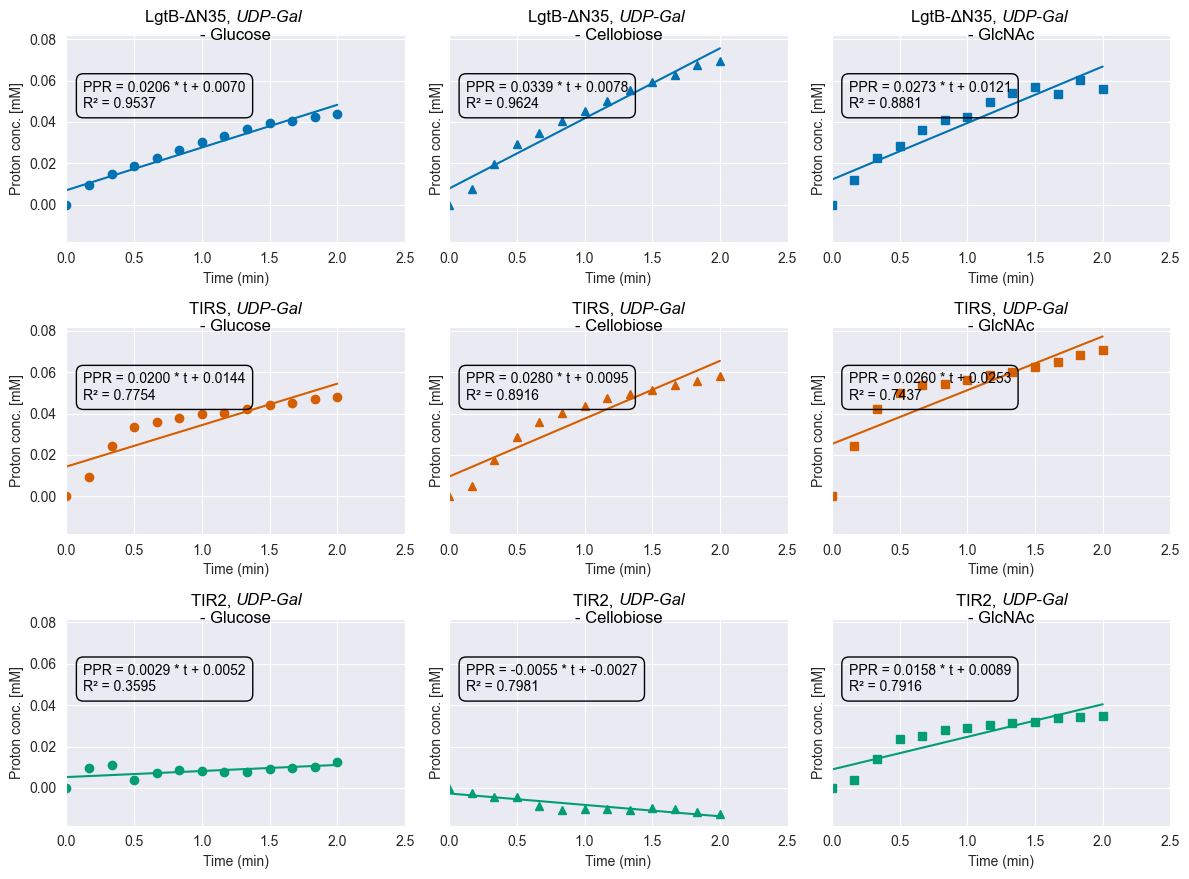

Enzyme: LgtB-ΔN35
  Glucose: 0.00041271 U/ml
  Cellobiose: 0.00067805 U/ml
  GlcNAc: 0.00054655 U/ml
Enzyme: TIRS
  Glucose: 0.00040064 U/ml
  Cellobiose: 0.00055939 U/ml
  GlcNAc: 0.00052004 U/ml
Enzyme: TIR2
  Glucose: 0.00005883 U/ml
  Cellobiose: -0.00011044 U/ml
  GlcNAc: 0.00031543 U/ml


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

# Load the Excel file
file_path = r'C:\Users\[...]\X.xlsx'
xls = pd.ExcelFile(file_path)

# Use Seaborn colorblind palette
palette = sns.color_palette("colorblind", 10)
enzyme_color_map = {
    "LgtB-ΔN35": palette[0],   # blue
    "TIRS": palette[3],   # red
    "TIR2": palette[2]    # green
}

# Define enzyme row indices
enzyme_rows = {
    "LgtB-ΔN35, UDP-Gal": (1, 13),
    "TIRS, UDP-Gal": (15, 27),
    "TIR2, UDP-Gal": (29, 41)
}

# Calibration curve parameters for each enzyme
calibration_curves = {
    "LgtB-ΔN35": {"m": -0.257, "b": 0.349},
    "TIRS": {"m": -0.233, "b": 0.343},
    "TIR2": {"m": -0.266, "b": 0.342}
}

# Extract data from sheets
data = {}
for sheet_name in ["Activity", "Blanks"]:
    df = xls.parse(sheet_name, header=None)
    sheet_data = {}
    for enzyme, (start, end) in enzyme_rows.items():
        enzyme_section = df.iloc[start:end]
        time_values = enzyme_section.iloc[1, 1:].astype(float).values
        temp_values = enzyme_section.iloc[2, 1:].astype(float).values
        temp_mean = np.mean(temp_values)

        substrates = {}
        i = 4
        while i < len(enzyme_section):
            if pd.notna(enzyme_section.iloc[i, 0]):
                substrate = enzyme_section.iloc[i, 0]
                values = []
                while i < len(enzyme_section) and enzyme_section.iloc[i, 0] == substrate:
                    values.append(enzyme_section.iloc[i, 1:].astype(float).values)
                    i += 1
                substrates[substrate] = np.asarray(values)
            else:
                i += 1

        sheet_data[enzyme] = {"time": time_values, "temp": temp_mean, "substrates": substrates}
    data[sheet_name] = sheet_data

# --- Time course plots ---
fig, axes = plt.subplots(len(enzyme_rows), 3, figsize=(12, 10), sharey=True)

# Define markers for each substrate
markers = {
    "Glucose": 'o',       # Circular
    "Cellobiose": '^',    # Triangular
    "GlcNAc": 's'         # Square
}

# Define total and enzyme volumes
total_volume = 0.00025  # Total volume in liters (250 microliters)
enzyme_volume = 0.0125  # Enzyme volume in ml (12.5 microliters)

# Dictionary to store enzyme activities for each enzyme and substrate
enzyme_activity = {}

for row_idx, enzyme in enumerate(enzyme_rows.keys()):
    enzyme_key = enzyme.split(',')[0]
    enzyme_color = enzyme_color_map.get(enzyme_key, 'blue')
    calib = calibration_curves[enzyme_key]
    m, b = calib["m"], calib["b"]

    enzyme_activity[enzyme_key] = {}

    for col_idx, substrate in enumerate(["Glucose", "Cellobiose", "GlcNAc"]):
        ax = axes[row_idx, col_idx]

        activity = data["Activity"][enzyme]["substrates"][substrate]
        blanks = data["Blanks"][enzyme]["substrates"][substrate]
        activity_time = data["Activity"][enzyme]["time"]
        blanks_time = data["Blanks"][enzyme]["time"]

        # Only use first 120 seconds (2 minutes)
        time_mask = activity_time <= 120
        activity_time_short = activity_time[time_mask] / 60  # convert to minutes

        interp_func = interp1d(blanks_time, blanks.mean(axis=0), kind='linear', fill_value='extrapolate')
        blanks_interp = interp_func(activity_time)

        # Linear regression on blank from 100s to 600s
        mask = (blanks_time >= 100) & (blanks_time <= 600)
        time_blanks_selected = blanks_time[mask]
        blanks_selected = blanks.mean(axis=0)[mask]

        model = LinearRegression()
        model.fit(time_blanks_selected.reshape(-1, 1), blanks_selected)
        regression_line = model.predict(activity_time.reshape(-1, 1))

        # Align sample to blank at t=0
        activity_mean = activity.mean(axis=0)
        activity_mean_shifted = activity_mean - activity_mean[0] + regression_line[0]

        # Corrected absorbance
        corrected_activity = activity_mean_shifted - regression_line

        # Convert to proton concentration
        proton_concentration = (corrected_activity - b) / m
        proton_conc_short = proton_concentration[time_mask]

        # Set proton concentration at time = 0 min to 0
        proton_conc_short -= proton_conc_short[0]  # Reset the first value to zero

        # Perform linear regression on proton concentration vs. time (first 2 minutes)
        model = LinearRegression()
        model.fit(activity_time_short.reshape(-1, 1), proton_conc_short)

        # Get the slope and intercept of the linear regression
        slope = model.coef_[0]
        intercept = model.intercept_

        # Get the R^2 value of the fit
        r_squared = model.score(activity_time_short.reshape(-1, 1), proton_conc_short)

        # Predict the proton concentration based on the linear regression model
        regression_line = model.predict(activity_time_short.reshape(-1, 1))

        # Calculate Enzyme Activity (U/ml)
        ppr = slope  # Proton production rate (PPR)
        enzyme_activity_value = (ppr * total_volume) / enzyme_volume  # in U/ml

        # Store enzyme activity for this enzyme and substrate
        enzyme_activity[enzyme_key][substrate] = enzyme_activity_value

        # Plot the data points and the regression line
        ax.plot(activity_time_short, proton_conc_short, marker=markers[substrate], color=enzyme_color, linestyle='None', label=enzyme_key)
        ax.plot(activity_time_short, regression_line, color=enzyme_color, linestyle='-', label=f'{enzyme_key} fit')

        # Display the equation and R² in the same frame
        equation = f'PPR = {slope:.4f} * t + {intercept:.4f}'
        r_squared_text = f'R² = {r_squared:.4f}'

        # Place the text within a frame with no background
        ax.text(0.05, 0.65, f'{equation}\n{r_squared_text}', transform=ax.transAxes, fontsize=10, color='black',
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))

        # Title with italic UDP-Gal
        enzyme_parts = enzyme.split("UDP-Gal")
        title_x = 0.5
        title_y = 1.05
        ax.set_title("")
        ax.text(title_x, title_y, enzyme_parts[0], transform=ax.transAxes,
                ha='right', va='bottom', fontsize=12, color='black')
        ax.text(title_x, title_y, "UDP-Gal", transform=ax.transAxes,
                ha='left', va='bottom', fontsize=12, color='black', style='italic')
        ax.text(title_x, title_y - 0.07, f"- {substrate}", transform=ax.transAxes,
                ha='center', fontsize=12, color='black')

        # Continue the plot until 2.5 minutes
        ax.set_xlim(0, 2.5)

        # Add labels
        ax.set_xlabel("Time (min)")
        ax.set_ylabel("Proton conc. [mM]")

plt.tight_layout(rect=[0, 0.07, 1, 0.96])
plt.show()

# Display enzyme activities
for enzyme in enzyme_activity:
    print(f"Enzyme: {enzyme}")
    for substrate, activity in enzyme_activity[enzyme].items():
        print(f"  {substrate}: {activity:.8f} U/ml")

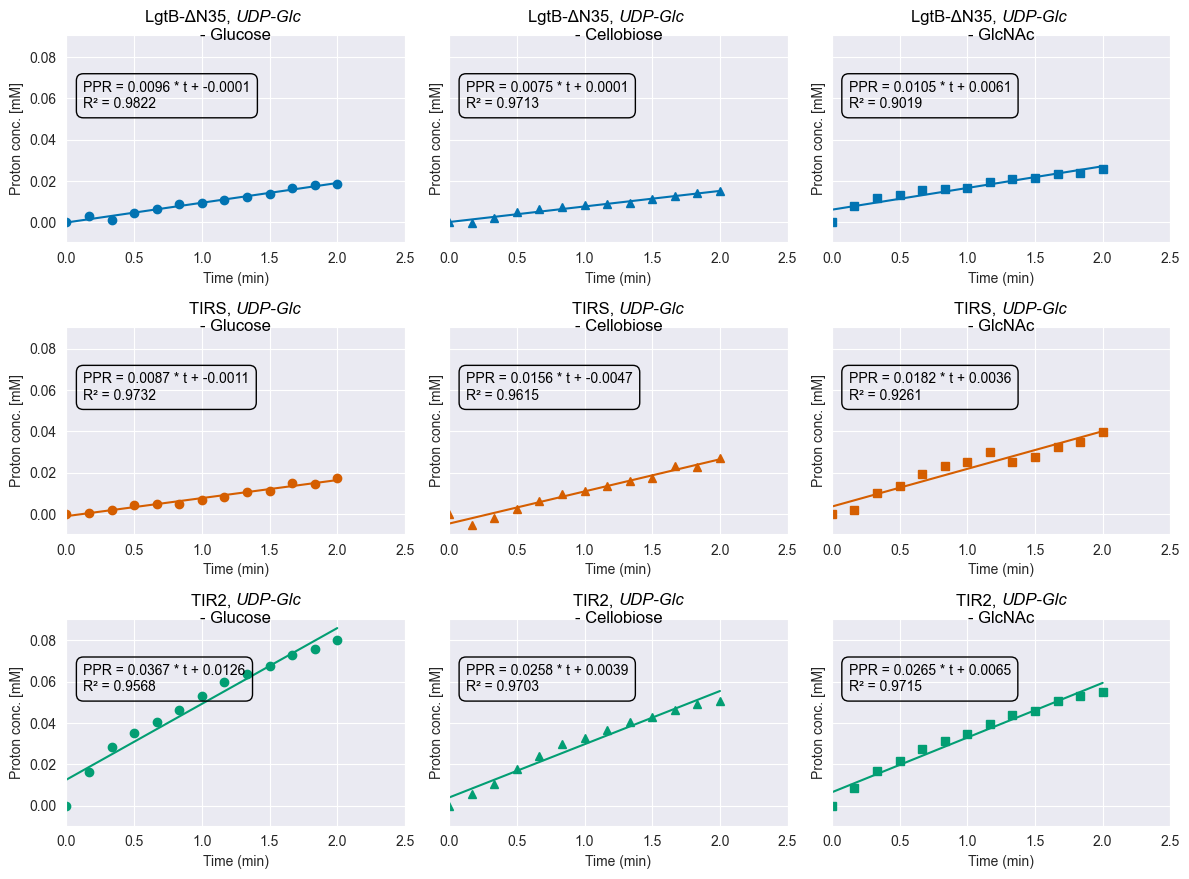

Enzyme: LgtB-ΔN35
  Glucose: 0.00019126 U/ml
  Cellobiose: 0.00015081 U/ml
  GlcNAc: 0.00021042 U/ml
Enzyme: TIRS
  Glucose: 0.00017471 U/ml
  Cellobiose: 0.00031152 U/ml
  GlcNAc: 0.00036497 U/ml
Enzyme: TIR2
  Glucose: 0.00073415 U/ml
  Cellobiose: 0.00051572 U/ml
  GlcNAc: 0.00052978 U/ml


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

# Load the Excel file
file_path = r'C:\Users\[...]\X.xlsx'
xls = pd.ExcelFile(file_path)

# Use Seaborn colorblind palette
palette = sns.color_palette("colorblind", 10)
enzyme_color_map = {
    "LgtB-ΔN35": palette[0],   # blue
    "TIRS": palette[3],   # red
    "TIR2": palette[2]    # green
}

# Define enzyme row indices
enzyme_rows = {
    "LgtB-ΔN35, UDP-Glc": (1, 13),
    "TIRS, UDP-Glc": (15, 27),
    "TIR2, UDP-Glc": (29, 41)
}

# Calibration curve parameters for each enzyme
calibration_curves = {
    "LgtB-ΔN35": {"m": -0.257, "b": 0.349},
    "TIRS": {"m": -0.233, "b": 0.343},
    "TIR2": {"m": -0.266, "b": 0.342}
}

# Extract data from sheets
data = {}
for sheet_name in ["Glc Activity", "Glc Blanks"]:
    df = xls.parse(sheet_name, header=None)
    sheet_data = {}
    for enzyme, (start, end) in enzyme_rows.items():
        enzyme_section = df.iloc[start:end]
        time_values = enzyme_section.iloc[1, 1:].astype(float).values
        temp_values = enzyme_section.iloc[2, 1:].astype(float).values
        temp_mean = np.mean(temp_values)

        substrates = {}
        i = 4
        while i < len(enzyme_section):
            if pd.notna(enzyme_section.iloc[i, 0]):
                substrate = enzyme_section.iloc[i, 0]
                values = []
                while i < len(enzyme_section) and enzyme_section.iloc[i, 0] == substrate:
                    values.append(enzyme_section.iloc[i, 1:].astype(float).values)
                    i += 1
                substrates[substrate] = np.asarray(values)
            else:
                i += 1

        sheet_data[enzyme] = {"time": time_values, "temp": temp_mean, "substrates": substrates}
    data[sheet_name] = sheet_data

# --- Time course plots ---
fig, axes = plt.subplots(len(enzyme_rows), 3, figsize=(12, 10), sharey=True)

# Define markers for each substrate
markers = {
    "Glucose": 'o',       # Circular
    "Cellobiose": '^',    # Triangular
    "GlcNAc": 's'         # Square
}

# Define total and enzyme volumes
total_volume = 0.00025  # Total volume in liters (250 microliters)
enzyme_volume = 0.0125  # Enzyme volume in ml (12.5 microliters)

# Dictionary to store enzyme activities for each enzyme and substrate
enzyme_activity = {}

for row_idx, enzyme in enumerate(enzyme_rows.keys()):
    enzyme_key = enzyme.split(',')[0]
    enzyme_color = enzyme_color_map.get(enzyme_key, 'blue')
    calib = calibration_curves[enzyme_key]
    m, b = calib["m"], calib["b"]

    enzyme_activity[enzyme_key] = {}

    for col_idx, substrate in enumerate(["Glucose", "Cellobiose", "GlcNAc"]):
        ax = axes[row_idx, col_idx]

        activity = data["Glc Activity"][enzyme]["substrates"][substrate]
        blanks = data["Glc Blanks"][enzyme]["substrates"][substrate]
        activity_time = data["Glc Activity"][enzyme]["time"]
        blanks_time = data["Glc Blanks"][enzyme]["time"]

        # Only use first 120 seconds (2 minutes)
        time_mask = activity_time <= 120
        activity_time_short = activity_time[time_mask] / 60  # convert to minutes

        interp_func = interp1d(blanks_time, blanks.mean(axis=0), kind='linear', fill_value='extrapolate')
        blanks_interp = interp_func(activity_time)

        # Linear regression on blank from 100s to 600s
        mask = (blanks_time >= 100) & (blanks_time <= 600)
        time_blanks_selected = blanks_time[mask]
        blanks_selected = blanks.mean(axis=0)[mask]

        model = LinearRegression()
        model.fit(time_blanks_selected.reshape(-1, 1), blanks_selected)
        regression_line = model.predict(activity_time.reshape(-1, 1))

        # Align sample to blank at t=0
        activity_mean = activity.mean(axis=0)
        activity_mean_shifted = activity_mean - activity_mean[0] + regression_line[0]

        # Corrected absorbance
        corrected_activity = activity_mean_shifted - regression_line

        # Convert to proton concentration
        proton_concentration = (corrected_activity - b) / m
        proton_conc_short = proton_concentration[time_mask]

        # Set proton concentration at time = 0 min to 0
        proton_conc_short -= proton_conc_short[0]  # Reset the first value to zero

        # Perform linear regression on proton concentration vs. time (first 2 minutes)
        model = LinearRegression()
        model.fit(activity_time_short.reshape(-1, 1), proton_conc_short)

        # Get the slope and intercept of the linear regression
        slope = model.coef_[0]
        intercept = model.intercept_

        # Get the R^2 value of the fit
        r_squared = model.score(activity_time_short.reshape(-1, 1), proton_conc_short)

        # Predict the proton concentration based on the linear regression model
        regression_line = model.predict(activity_time_short.reshape(-1, 1))

        # Calculate Enzyme Activity (U/ml)
        ppr = slope  # Proton production rate (PPR)
        enzyme_activity_value = (ppr * total_volume) / enzyme_volume  # in U/ml

        # Store enzyme activity for this enzyme and substrate
        enzyme_activity[enzyme_key][substrate] = enzyme_activity_value

        # Plot the data points and the regression line
        ax.plot(activity_time_short, proton_conc_short, marker=markers[substrate], color=enzyme_color, linestyle='None', label=enzyme_key)
        ax.plot(activity_time_short, regression_line, color=enzyme_color, linestyle='-', label=f'{enzyme_key} fit')

        # Display the equation and R² in the same frame
        equation = f'PPR = {slope:.4f} * t + {intercept:.4f}'
        r_squared_text = f'R² = {r_squared:.4f}'

        # Place the text within a frame with no background
        ax.text(0.05, 0.65, f'{equation}\n{r_squared_text}', transform=ax.transAxes, fontsize=10, color='black',
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))

        # Title with italic UDP-Glc
        enzyme_parts = enzyme.split("UDP-Glc")
        title_x = 0.5
        title_y = 1.05
        ax.set_title("")
        ax.text(title_x, title_y, enzyme_parts[0], transform=ax.transAxes,
                ha='right', va='bottom', fontsize=12, color='black')
        ax.text(title_x, title_y, "UDP-Glc", transform=ax.transAxes,
                ha='left', va='bottom', fontsize=12, color='black', style='italic')
        ax.text(title_x, title_y - 0.07, f"- {substrate}", transform=ax.transAxes,
                ha='center', fontsize=12, color='black')

        # Continue the plot until 2.5 minutes
        ax.set_xlim(0, 2.5)

        # Add labels
        ax.set_xlabel("Time (min)")
        ax.set_ylabel("Proton conc. [mM]")

# Remove the legend
#fig.legend(handles=legend_handles, loc='lower center', ncol=3, fontsize=10, frameon=False)

plt.tight_layout(rect=[0, 0.07, 1, 0.96])
plt.show()

# Display enzyme activities
for enzyme in enzyme_activity:
    print(f"Enzyme: {enzyme}")
    for substrate, activity in enzyme_activity[enzyme].items():
        print(f"  {substrate}: {activity:.8f} U/ml")

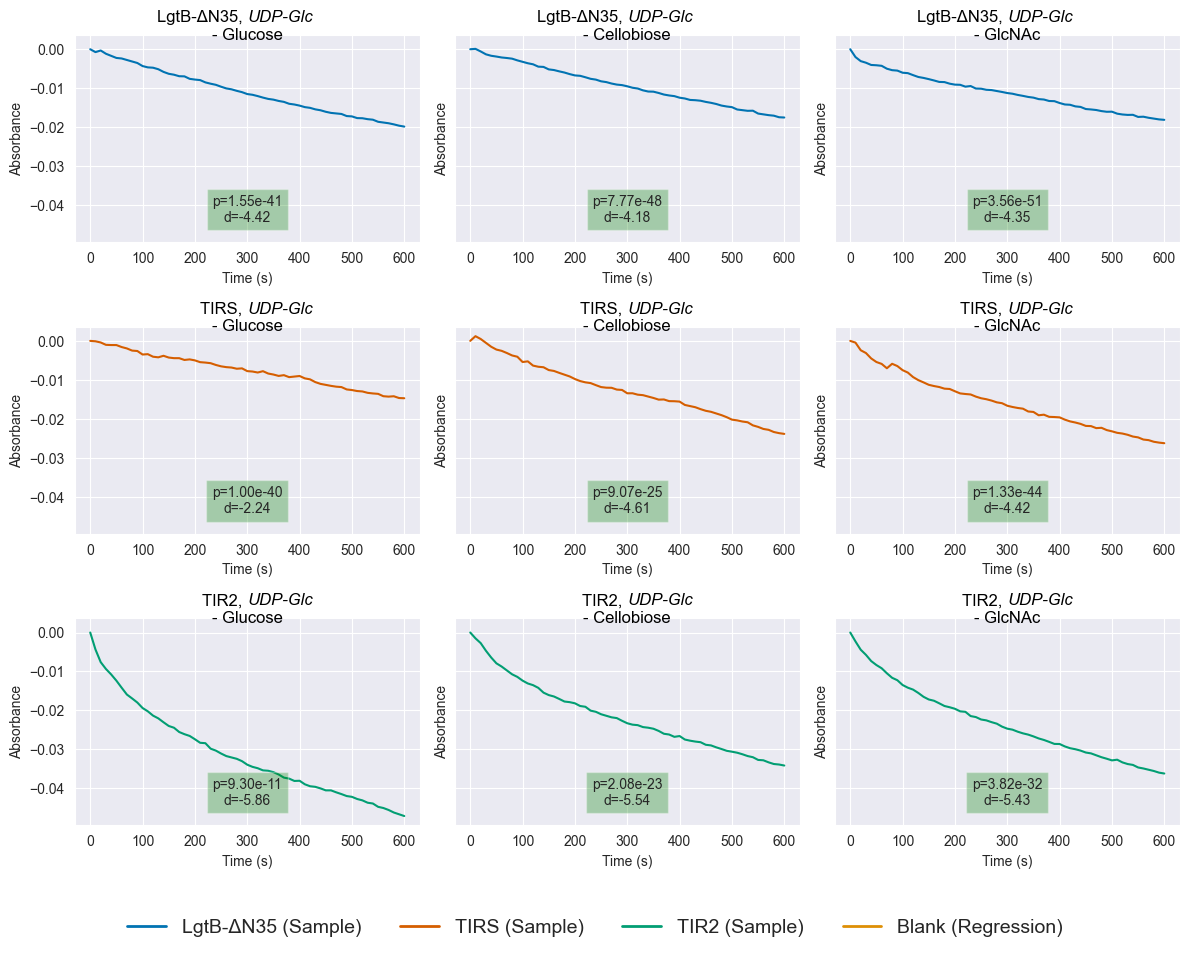

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_rel
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

# Load the Excel file
file_path = r'C:\Users\[...]\X.xlsx'
xls = pd.ExcelFile(file_path)

# Use Seaborn colorblind palette
palette = sns.color_palette("colorblind", 10)
enzyme_color_map = {
    "LgtB-ΔN35": palette[0],   # blue
    "TIRS": palette[3],   # red
    "TIR2": palette[2]    # green
}
blank_color = palette[1]  # orange

# Define enzyme row indices
enzyme_rows = {
    "LgtB-ΔN35, UDP-Glc": (1, 13),
    "TIRS, UDP-Glc": (15, 27),
    "TIR2, UDP-Glc": (29, 41)
}

# Extract data from sheets
data = {}
for sheet_name in ["Glc Activity", "Glc Blanks"]:
    df = xls.parse(sheet_name, header=None)
    sheet_data = {}
    for enzyme, (start, end) in enzyme_rows.items():
        enzyme_section = df.iloc[start:end]
        time_values = enzyme_section.iloc[1, 1:].astype(float).values
        temp_values = enzyme_section.iloc[2, 1:].astype(float).values
        temp_mean = np.mean(temp_values)

        substrates = {}
        i = 4
        while i < len(enzyme_section):
            if pd.notna(enzyme_section.iloc[i, 0]):
                substrate = enzyme_section.iloc[i, 0]
                values = []
                while i < len(enzyme_section) and enzyme_section.iloc[i, 0] == substrate:
                    values.append(enzyme_section.iloc[i, 1:].astype(float).values)
                    i += 1
                substrates[substrate] = np.asarray(values)
            else:
                i += 1

        sheet_data[enzyme] = {"time": time_values, "temp": temp_mean, "substrates": substrates}
    data[sheet_name] = sheet_data

# --- Time course plots ---
fig, axes = plt.subplots(len(enzyme_rows), 3, figsize=(12, 10), sharey=True)

for row_idx, enzyme in enumerate(enzyme_rows.keys()):
    enzyme_key = enzyme.split(',')[0]
    enzyme_color = enzyme_color_map.get(enzyme_key, 'blue')

    for col_idx, substrate in enumerate(["Glucose", "Cellobiose", "GlcNAc"]):
        ax = axes[row_idx, col_idx]

        activity = data["Glc Activity"][enzyme]["substrates"][substrate]
        blanks = data["Glc Blanks"][enzyme]["substrates"][substrate]
        activity_time = data["Glc Activity"][enzyme]["time"]
        blanks_time = data["Glc Blanks"][enzyme]["time"]

        interp_func = interp1d(blanks_time, blanks.mean(axis=0), kind='linear', fill_value='extrapolate')
        blanks_interp = interp_func(activity_time)

        # Perform linear regression on blanks mean values starting from 100s to 600s
        mask = (blanks_time >= 100) & (blanks_time <= 600)
        time_blanks_selected = blanks_time[mask]
        blanks_selected = blanks.mean(axis=0)[mask]

        model = LinearRegression()
        model.fit(time_blanks_selected.reshape(-1, 1), blanks_selected)

        # Create regression line for blanks
        regression_line = model.predict(activity_time.reshape(-1, 1))

        # Align activity curve to start at the same value as the regression line
        activity_mean = activity.mean(axis=0)
        activity_mean_shifted = activity_mean - activity_mean[0] + regression_line[0]

        # Subtract the linear regression of the blank from the activity to get the corrected absorbance
        corrected_activity = activity_mean_shifted - regression_line

        # Plot corrected activity (no regression line for blank)
        ax.plot(activity_time, corrected_activity, color=enzyme_color)  # Corrected activity only

        # p-value box (optional)
        p_value = ttest_rel(activity_mean, blanks_interp).pvalue
        significant = p_value < 0.05

        pooled_std = np.sqrt((np.std(activity.mean(axis=0))**2 + np.std(blanks_interp)**2) / 2)
        effect_size = (activity_mean_shifted[-1] - activity_mean_shifted[0] - blanks_interp[-1] + blanks_interp[0]) / pooled_std

        color = "green" if significant else "red"
        ax.text(0.5, 0.1, f"p={p_value:.2e}\nd={effect_size:.2f}",
                transform=ax.transAxes, fontsize=10, ha='center', bbox=dict(facecolor=color, alpha=0.3))

        # Title with italic UDP-Glc
        enzyme_parts = enzyme.split("UDP-Glc")
        title_x = 0.5
        title_y = 1.05
        ax.set_title("")
        ax.text(title_x, title_y, enzyme_parts[0], transform=ax.transAxes,
                ha='right', va='bottom', fontsize=12, color='black')
        ax.text(title_x, title_y, "UDP-Glc", transform=ax.transAxes,
                ha='left', va='bottom', fontsize=12, color='black', style='italic')
        ax.text(title_x, title_y - 0.07, f"- {substrate}", transform=ax.transAxes,
                ha='center', fontsize=12, color='black')

        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Absorbance")

# Add legend
legend_handles = [
    plt.Line2D([0], [0], color=palette[0], label='LgtB-ΔN35 (Sample)', linewidth=2),
    plt.Line2D([0], [0], color=palette[3], label='TIRS (Sample)', linewidth=2),
    plt.Line2D([0], [0], color=palette[2], label='TIR2 (Sample)', linewidth=2),
    plt.Line2D([0], [0], color=blank_color, label='Blank (Regression)', linewidth=2),
]
fig.legend(handles=legend_handles, loc='lower center', ncol=4, fontsize=14, frameon=False)

plt.tight_layout(rect=[0, 0.07, 1, 0.96])
plt.show()

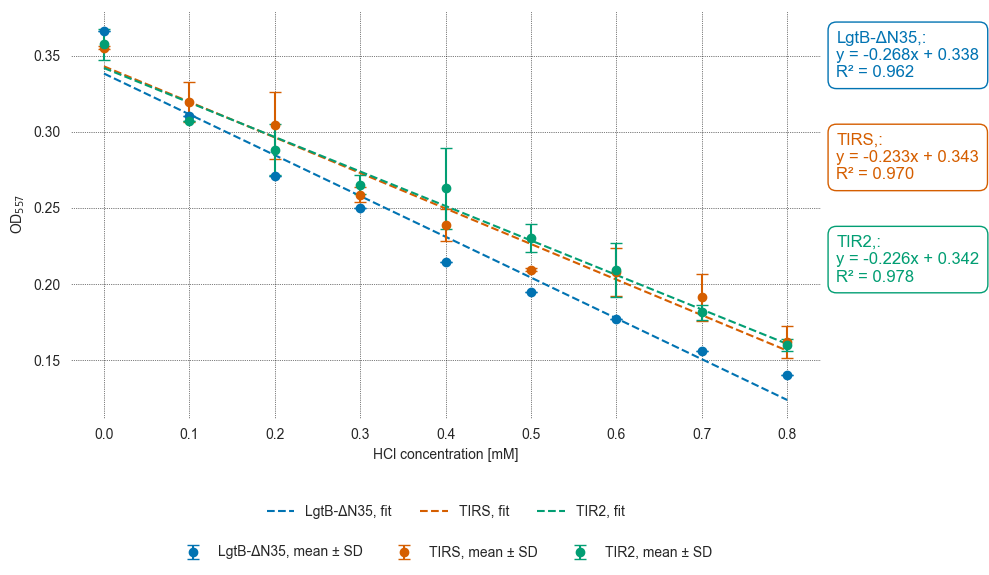

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# File and sheet details
file_path = r'C:\Users\[...]\X.xlsx'
sheet_name = "Calibration"
df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)

# Extract concentrations (1D array)
concentrations = df.iloc[0, 1:].values.astype(float)

# Seaborn colorblind palette
palette = sns.color_palette("colorblind", 10)
color_map = {
    'LgtB-ΔN35,': palette[0],
    'TIRS,': palette[3],
    'TIR2,': palette[2],
}

# Enzyme names and data storage
enzymes = ['LgtB-ΔN35,', 'TIRS,', 'TIR2,']
data = {enzyme: [] for enzyme in enzymes}
equation_elements = []

# Extract enzyme data
for i in range(1, df.shape[0]):
    enzyme = df.iloc[i, 0]
    if enzyme in data:
        data[enzyme].append(df.iloc[i, 1:].values.astype(float))

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(True, color='black', linestyle=':', linewidth=0.5)

# To track handles for custom legend arrangement
fit_handles = []
mean_handles = []

for enzyme in enzymes:
    enzyme_data = np.array(data[enzyme])

    # Ensure enzyme_data has more than one row (ultiple measurements)
    if enzyme_data.ndim == 1:
        enzyme_data = enzyme_data.reshape(1, -1)  # Reshape to 2D array (one row, multiple columns)

    means = enzyme_data.mean(axis=0)
    stds = enzyme_data.std(axis=0)

    # Ensure means and concentrations have the same length
    if len(means) != len(concentrations):
        raise ValueError(f"Mismatch in data length: {enzyme} has {len(means)} means but {len(concentrations)} concentrations.")

    # Error bars (means)
    mean_plot = ax.errorbar(
        concentrations, means, yerr=stds, fmt='o', capsize=4,
        label=f"{enzyme} mean ± SD", color=color_map[enzyme]
    )
    mean_handles.append(mean_plot)

    # Linear regression
    X = concentrations.reshape(-1, 1)  # Ensure it is 2D for linear regression
    y = means
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Regression line
    fit_plot, = ax.plot(concentrations, y_pred, '--', color=color_map[enzyme],
                        label=f"{enzyme} fit")
    fit_handles.append(fit_plot)

    # Store color-coded equation string for later annotation
    equation_text = f"{enzyme}:\ny = {model.coef_[0]:.3f}x + {model.intercept_:.3f}\nR² = {r2:.3f}"
    equation_elements.append((equation_text, color_map[enzyme]))

# Combine and annotate all equations in top-right, color coded
for idx, (text, color) in enumerate(equation_elements):
    ax.text(
        1.02, 0.95 - idx * 0.25, text,
        transform=ax.transAxes,
        fontsize=12,
        color=color,
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.5')
    )

# Axis labels
ax.set_xlabel("HCl concentration [mM]")
ax.set_ylabel("OD$_{557}$")

# Two-line legend: fits on top, means below
legend1 = ax.legend(
    handles=fit_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=3,
    frameon=False
)
legend2 = ax.legend(
    handles=mean_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.28),
    ncol=3,
    frameon=False
)
ax.add_artist(legend1)

plt.tight_layout()
plt.show()